# Import Libraries

In [2]:
import uproot
import time
import infofile

import numpy as np
import pandas as pd
import mplhep as hep
import uproot_methods.classes.TLorentzVector as LVepm
import matplotlib.pyplot as plt

from numpy import pi, sqrt, sin, cos, linspace, zeros, arctan, exp, tan, arccos
from scipy import stats

from numpy import array as arr
from numpy import append as app
from pandas import DataFrame

print('import success')

import success


# Useful Functions

In [39]:
# determine net simulation weight
def get_xsec_weight(sample):
    info = infofile.infos[sample]
    xsec_weight = (lumi*1000*info['xsec'])/(info['sumw']*info['red_eff'])
    return xsec_weight

# File Names and Directories

In [40]:
# monte-carlo simulation data
mc_files = ['mc_361106.Zee.4lep.root',
            'mc_361107.Zmumu.4lep.root',
            'mc_410000.ttbar_lep.4lep.root',
            'mc_363490.llll.4lep.root',
            'mc_363492.llvv.4lep.root',
            'mc_363356.ZqqZll.4lep.root',    
            'mc_345060.ggH125_ZZ4lep.4lep.root',
            'mc_341964.WH125_ZZ4lep.4lep.root',
            'mc_344235.VBFH125_ZZ4lep.4lep.root',
            'mc_341947.ZH125_ZZ4lep.4lep.root']

# actual data
data_files = ['data_A.4lep.root',
              'data_B.4lep.root',
              'data_C.4lep.root',
              'data_D.4lep.root']

# add directory to file names
mc_files = ['4lep/MC/' + file_name for file_name in mc_files]
data_files = ['4lep/Data/' + file_name for file_name in data_files]

# bring 'em all together
all_files = mc_files + data_files

# Global Variables

In [41]:
# luminosity (fb) and bin number
lumi = 10
nBins = 34

# mass range, in GeV
h_min, h_max = 80, 250

btagWP77 = 0.6459
zPDG = 91188

# Read Files Into Initial Dataframe

In [42]:
def read_file(file: str=None, fam: int=None):
    btagWP77 = 0.6459
    
    name = file.split('.')[1] 
    # sample_names.append(name)
    Type = file.split('/')[1]
    tree = uproot.open(file)['mini']
    
    names = ['mcWeight', 'SumWeights', 'XSection', 'trigM', 'trigE', 'scaleFactor_PILEUP', 
             'scaleFactor_ELE', 'scaleFactor_MUON', 'scaleFactor_LepTRIGGER', 'lep_type', 
             'lep_pt', 'lep_eta', 'lep_phi', 'lep_E', 'lep_charge', 'lep_etcone20', 
             'lep_ptcone30', 'jet_n', 'jet_pt', 'jet_eta', 'jet_phi', 'jet_E', 'jet_MV2c10']
    
    # get info from tree
    (mcWeight, SumWeights, XSection, trigM, trigE, scaleFactor_PILEUP, scaleFactor_ELE, 
    scaleFactor_MUON,scaleFactor_LepTRIGGER, lep_type, lep_pt, lep_eta, lep_phi, lep_E, 
    lep_charge, lep_etcone20, lep_ptcone30, jet_n, jet_pt, jet_eta, jet_phi, jet_E, 
    jet_MV2c10) = tree.arrays(names, outputtype=tuple)
    
    
    leplv = LVepm.TLorentzVectorArray.from_ptetaphi(lep_pt, lep_eta, lep_phi, lep_E)

    lep_reliso_pt = (lep_ptcone30 / lep_pt)
    lep_reliso_et = (lep_etcone20 / lep_pt)
    sum_lep_type = lep_type.sum()
    
    jetlv = LVepm.TLorentzVectorArray.from_ptetaphi(jet_pt, jet_eta, jet_phi, jet_E)
    jetlv = jetlv[jet_MV2c10.argsort()]    
    tags = jet_pt[jet_MV2c10 > btagWP77]
    
    cuts = {'trig_cut': ( (trigM == 1) | (trigE == 1) ), 
            'lep_pt_cut': ( (lep_pt.max() > 20000) & (lep_pt.min() > 7000) ), 
            'lep_eta_cut': ( (lep_eta.min() >- 2.5) & (lep_eta.max() < 2.5) ), 
            'lep_type_cut': ( (sum_lep_type == 44) | (sum_lep_type == 48) | (sum_lep_type == 52) ),
            'lep_iso_cut': ( (lep_reliso_pt.max() < 0.3) & (lep_reliso_pt.max() < 0.3) ),
            'lept_count_cut': ( leplv.counts == 4 ),
            'lept_charge_cut': ( lep_charge.sum()== 0 )}
    
    cut = True
    for boolean in cuts.values():
        cut &= boolean
    
    if True:
        (mcWeight, SumWeights, XSection, trigM, trigE, scaleFactor_PILEUP, scaleFactor_ELE, 
        scaleFactor_MUON,scaleFactor_LepTRIGGER, lep_type, lep_pt, lep_eta, lep_phi, lep_E, 
        lep_charge, lep_etcone20, lep_ptcone30, jet_n, jet_pt, jet_eta, jet_phi, jet_E, 
        jet_MV2c10) = (mcWeight[cut], SumWeights[cut], XSection[cut], trigM[cut], trigE[cut], 
                       scaleFactor_PILEUP[cut], scaleFactor_ELE[cut], scaleFactor_MUON[cut], 
                       scaleFactor_LepTRIGGER[cut], lep_type[cut], lep_pt[cut], lep_eta[cut], 
                       lep_phi[cut], lep_E[cut], lep_charge[cut], lep_etcone20[cut], 
                       lep_ptcone30[cut], jet_n[cut], jet_pt[cut], jet_eta[cut], jet_phi[cut], 
                       jet_E[cut], jet_MV2c10[cut])
    
    if(Type == 'MC'):
        a1 = get_xsec_weight(name)*(mcWeight)*(scaleFactor_PILEUP)
        a2 = (scaleFactor_ELE)*(scaleFactor_MUON)*(scaleFactor_LepTRIGGER)
        finalWeight = a1*a2
    else:
        finalWeight = np.ones(len(lep_type))
        
    df = (mcWeight, SumWeights, XSection, trigM, trigE, scaleFactor_PILEUP, scaleFactor_ELE, 
          scaleFactor_MUON,scaleFactor_LepTRIGGER, lep_type, lep_pt, lep_eta, lep_phi, lep_E, 
          lep_charge, lep_etcone20, lep_ptcone30, jet_n, jet_pt, jet_eta, jet_phi, jet_E, 
          jet_MV2c10, lep_type.sum(), finalWeight)
    
    names = ['mcWeight', 'SumWeights', 'XSec', 'trigM', 'trigE', 'SF_PILEUP', 'SF_ELE', 'SF_MUON', 
             'SF_LepTRIGGER', 'lep_type', 'lep_pt', 'lep_eta', 'lep_phi', 'lep_E', 'lep_charge', 
             'lep_etcone20', 'lep_ptcone30', 'jet_n', 'jet_pt', 'jet_eta', 'jet_phi', 'jet_E', 
             'jet_MV2c10', 'sum_lep_type', 'w']

    df = pd.DataFrame( dict( zip(names, df) ) )
    
    if 'H125' in file:
        df['sig?'] = 1
    else:
        df['sig?'] = 0
        
    df['fam'] = fam/4
    
    if True:
        df.drop(labels=['mcWeight', 'SumWeights', 'XSec', 'trigM', 'trigE', 'SF_PILEUP', 'SF_ELE', 
                       'SF_MUON', 'SF_LepTRIGGER', 'jet_n', 'jet_pt', 'jet_eta', 'jet_phi', 
                        'jet_E', 'jet_MV2c10'], axis=1, inplace=True)
    
    return df

def read_files(files: list=None):
    frames = [read_file(file, fam) for fam, file in enumerate(files)]
    out = pd.concat(frames)

    i = linspace(0, len(out)-1, len(out))
    out.set_index(keys=i, inplace=True)
    out['id'] = i

    d = {'lep_type': 'type', 'lep_pt': 'pt', 'lep_eta': 'eta', 'lep_phi': 'phi', 'lep_E': 'E',
        'lep_charge': 'Q', 'lep_etcone20': 'etc20', 'lep_ptcone30': 'ptc30'}

    out = out.rename(mapper=d, axis=1, inplace=False)
    out.drop(labels=['etc20', 'ptc30'], axis=1, inplace=True)
    
    return out

DF = read_files(all_files)
DF

,type,pt,eta,phi,E,Q,sum_lep_type,w,sig?,fam,id
0.0,"[11, 11, 11, 11]","[47592.39, 43458.098, 10026.11, 7162.6626]","[-0.8090483, -0.6145289, 2.0875025, 0.6384636]","[-2.2826285, 0.6541073, 0.18135798, 0.8925741]","[64036.78, 51925.496, 41050.63, 8672.812]","[-1, 1, -1, 1]",44,0.169451,0,0.00,0.0
1.0,"[11, 11, 13, 13]","[51710.316, 30980.805, 11872.697, 7892.9395]","[2.211758, 1.0357504, -1.5491847, -0.49692452]","[3.0596266, -0.21164392, -0.018451305, 2.6533346]","[238934.31, 49138.336, 29207.332, 8888.304]","[-1, 1, -1, 1]",48,0.174886,0,0.00,1.0
2.0,"[11, 11, 11, 11]","[65519.844, 17793.098, 14570.528, 7871.123]","[-1.8400015, 0.014194325, 0.10441768, 0.54491776]","[0.4868397, -2.3558335, -1.6149002, -2.8749647]","[211477.25, 17794.89, 14650.032, 9068.935]","[-1, -1, 1, 1]",44,0.381443,0,0.00,2.0
3.0,"[11, 11, 13, 13]","[39427.957, 32687.89, 8821.469, 8123.534]","[0.6319882, -0.72217596, 0.5735928, -0.06887347]","[2.225151, -1.306289, 1.8235722, -1.0468655]","[47567.492, 41588.848, 10313.406, 8143.4946]","[-1, 1, 1, -1]",48,0.166324,0,0.00,3.0
4.0,"[11, 11, 13, 13]","[49097.43, 18737.934, 11769.221, 7947.696]","[-1.0622535, 0.8695862, -1.5491946, -0.4963608]","[2.2721536, -1.0716466, -0.018504394, 2.653314]","[79502.45, 26280.404, 28953.041, 8947.64]","[1, -1, -1, 1]",48,0.156882,0,0.00,4.0
...,...,...,...,...,...,...,...,...,...,...,...
818086.0,"[11, 11, 11, 11]","[51773.375, 51708.45, 51148.297, 30737.582]","[-1.28635, -1.0202633, -0.80568916, 0.30312154]","[1.1772112, -1.047273, -1.4184802, 2.3813634]","[100850.09, 81038.13, 68667.06, 32160.553]","[-1, 1, 1, -1]",44,1.000000,0,3.25,818086.0
818087.0,"[13, 13, 13, 13]","[61561.816, 25231.277, 21982.31, 14411.031]","[-0.6561884, -0.043175437, 0.49340436, -0.2145...","[3.0332172, 1.3050667, 0.06840056, 2.7004883]","[75298.086, 25255.02, 24713.037, 14744.3125]","[1, -1, -1, 1]",52,1.000000,0,3.25,818087.0
818088.0,"[13, 13, 13, 13]","[53048.145, 39838.145, 23835.697, 7428.501]","[1.6669953, 1.2820495, 0.009336205, 1.5172257]","[1.6207898, -1.2548615, -2.9835243, -0.25539052]","[145485.73, 77315.69, 23836.97, 17750.264]","[-1, 1, 1, -1]",52,1.000000,0,3.25,818088.0
818089.0,"[11, 11, 11, 11]","[114072.234, 113360.6, 64472.6, 26180.354]","[1.6677951, 1.1956723, 1.5933089, 1.2851827]","[0.0551456, 3.0626664, -0.9325686, -1.999637]","[313078.7, 204518.39, 165154.75, 50946.03]","[1, 1, -1, -1]",44,1.000000,0,3.25,818089.0


# Process DataFrame

In [45]:
# functions stored and edited in separate .py file, to keep this notebook manageable
from DataFrame_Processing_Functions import partner_eeuu, partner_llll
from DataFrame_Processing_Functions import mass_compare_eeuu, mass_compare_llll
from DataFrame_Processing_Functions import cart, MnM, dot, get_angles, merge, pipeline

print('import success')

import success


In [ ]:
# export data to csv, only run this cell to update processed dataframe, as it takes a while
pipeline(DF, subset='all')

In [3]:
# read in data
V = pd.read_csv('DataFrame.csv')
V.set_index('id', inplace=True)
V

,L0 type,L0 E,L0 Q,L0 px,L0 py,L0 pz,L0 p,L0 a,L1 type,L1 E,...,E,Q,w,sig?,fam,px,py,pz,p,m
id,,,,,,,,,,,,,,,,,,,,,
0.0,11.0,41050.628906,-1.0,1808.363883,9861.678805,39807.426332,41050.628253,0.130773,11.0,8672.811523,...,165685.717773,0.0,0.169451,0.0,0.0,-2207.377847,17755.172571,-26566.351879,32029.513299,162560.349876
1.0,11.0,238934.312500,-1.0,4233.747224,-51536.707377,233271.623877,238934.315930,0.141727,11.0,49138.335938,...,326168.284180,0.0,0.174886,0.0,0.0,1209.119766,-16347.164128,240642.264655,241199.899013,219564.018730
2.0,11.0,211477.250000,-1.0,30652.483728,57907.470730,-201071.564622,211477.242332,0.068085,11.0,14650.032227,...,252991.107422,0.0,0.381443,0.0,0.0,1436.079667,37094.988386,-194790.254596,198296.101257,157108.741516
3.0,11.0,47567.492188,-1.0,31283.751030,-23997.723166,26610.193752,47567.491075,1.018484,11.0,41588.847656,...,107613.240723,0.0,0.166324,0.0,0.0,1240.001057,-13594.084004,5679.720076,14784.990452,106592.746640
4.0,11.0,26280.404297,-1.0,-16451.715946,8969.459171,18426.869741,26280.404940,2.865924,11.0,79502.453125,...,143683.538086,0.0,0.156882,0.0,0.0,24567.648931,-17962.648813,-74665.543324,80629.830003,118927.665539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818086.0,11.0,100850.093750,-1.0,47814.786986,19855.188350,-86546.282613,100850.093669,0.479502,11.0,81038.132812,...,282715.841797,0.0,1.000000,0.0,13.0,-26343.225786,31191.804669,-185297.981470,189742.552318,209585.331173
818087.0,13.0,24713.037109,-1.0,1502.430197,21930.906969,11291.635205,24712.810495,0.562848,13.0,14744.312500,...,140010.455078,0.0,1.000000,0.0,13.0,38659.478189,-45675.281627,-36271.672918,69974.430057,121270.386614
818088.0,13.0,145485.734375,-1.0,52981.865557,-2650.954608,135469.488805,145485.697013,0.305213,13.0,77315.687500,...,264388.656250,0.0,1.000000,0.0,13.0,9486.845750,-6624.023097,218074.564557,218381.303300,149033.445651


# Z Mass Comparison
Plot the mass distribution of the real and virtual Z.

<IPython.core.display.Javascript object>


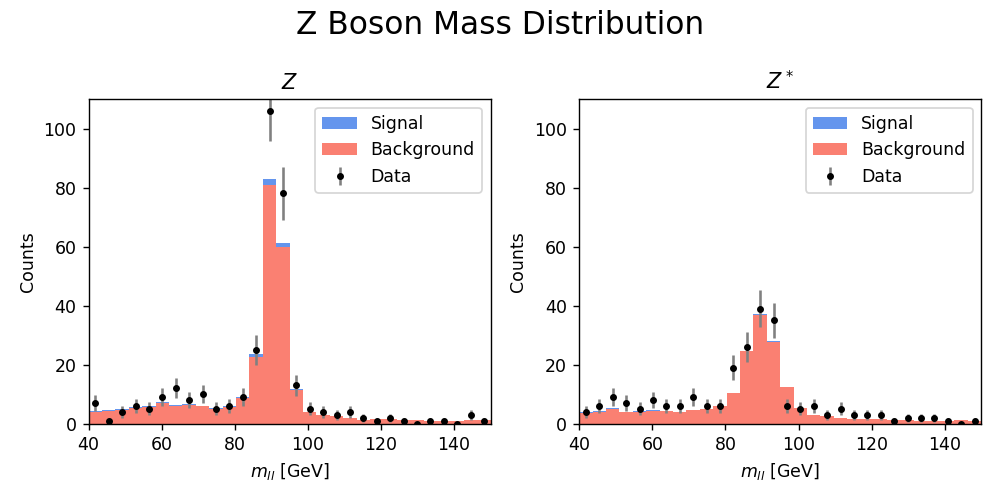

In [32]:
%matplotlib notebook

# split data into simulated and 'real'
sim = V[V['fam'] <= 9]
dat = V[V['fam'] >= 10]

nBins = 30
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
z_descriptions = {0: r'$Z$', 1: r'$Z^*$'}
ran = (40, 150)
for i, name in enumerate(['Z0', 'Z1']):
    name += ' m'
    for df, lab in zip([sim, dat], ['MC', 'Data']):
        if lab == 'MC':
            bkg = df[df['sig?'] == 0]
            ax[i].hist(df[name]/1000, bins=nBins, range=ran, weights=df['w'], 
                       label='Signal', color='cornflowerblue')
            ax[i].hist(bkg[name]/1000, bins=nBins, range=ran, weights=bkg['w'], 
                       label='Background', color='salmon')
        else:
            counts, bins = np.histogram(df[name]/1000, bins=nBins, 
                                        range=ran, weights=df['w'])
            cents = ( bins[1:] + bins[:-1] ) / 2
            ax[i].errorbar(cents, counts, yerr=sqrt(counts), fmt='.k', label=lab, ecolor='grey')
        ax[i].set_xlabel(r'$m_{ll}$ [GeV]')
        ax[i].set_ylabel('Counts')
        ax[i].set_xlim(*ran)
        ax[i].set_ylim(0, 110)
        ax[i].set_title(z_descriptions[i])
        ax[i].legend()
fig.suptitle('Z Boson Mass Distribution', fontsize=18)
fig.tight_layout()
fig.show()

The standard model simulation seeems to match the mass distribution of the virtual boson better than that of the Z-boson. The distribution of the real Z is clearly more sharply peaked around the known Z-mass (~91 GeV). However, this does not yield much information on the efficacy of the pairing algorithm, i.e., whether or not it effectively determined the correct pairing of the leptons.

# Z Scatter Angles
The following plots show the distribution of the 2 Z angles, which are the angles that the momentum vector of the Z bosons make with the momentum vector of their parent Higgs. Note that the indices in the figure on the right are merely to label the particles consistently with the variable names in the notebook, and do not have any physical meaning.
<table><tr><td><img src='hzz.png' width="290"></td><td><img src="H-ZZ-llll.drawio.png" width=300></td></tr></table>

<IPython.core.display.Javascript object>


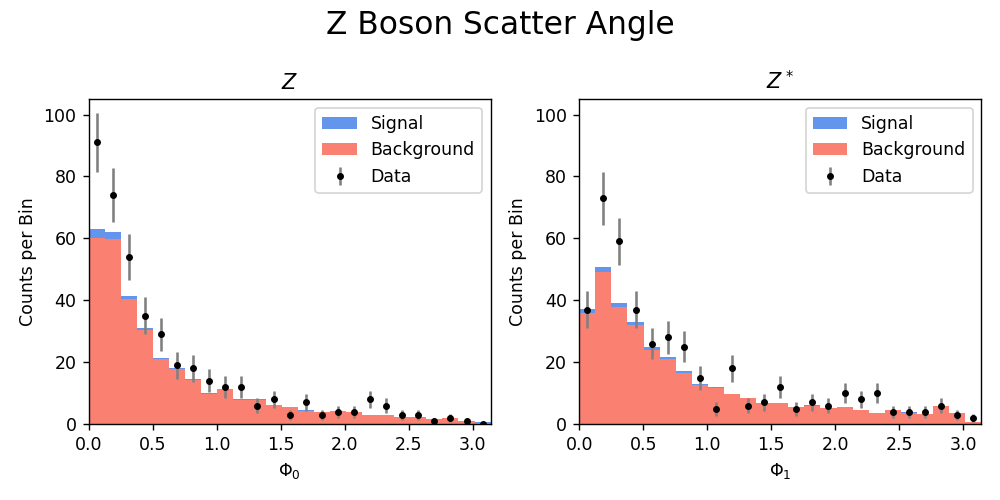

In [36]:
%matplotlib notebook
# Z angles
nBins = 25
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
z_descriptions = {0: r'$Z$', 1: r'$Z^*$'}
for i, name in enumerate(['Z0', 'Z1']):
    name += ' a'
    for df, lab in zip([sim, dat], ['MC', 'Data']):
        if lab == 'MC':
            bkg = df[df['sig?'] == 0]
            ax[i].hist(df[name], bins=nBins, range=(0, pi), weights=df['w'], 
                       label='Signal', color='cornflowerblue')
            ax[i].hist(bkg[name], bins=nBins, range=(0, pi), weights=bkg['w'], 
                       label='Background', color='salmon')
        else:
            counts, bins = np.histogram(df[name], bins=nBins, range=(0, pi), weights=df['w'])
            cents = ( bins[1:] + bins[:-1] ) / 2
            ax[i].errorbar(cents, counts, yerr=sqrt(counts), fmt='.k', label=lab, ecolor='grey')
        ax[i].set_xlabel(r'$\Phi$'+f'$_{i}$')
        ax[i].set_ylabel('Counts per Bin')
        ax[i].set_xlim(0, pi)
        ax[i].set_ylim(0, 105)
        ax[i].set_title(z_descriptions[i])
        ax[i].legend()
fig.suptitle('Z Boson Scatter Angle', fontsize=18)
fig.tight_layout()
fig.show()

# Lepton Scatter Angles
These plots show the distribution of the 4 lepton angles, which are the angles that the momentum vector of each lepton makes with the momentum vector of its parent Z.

<IPython.core.display.Javascript object>


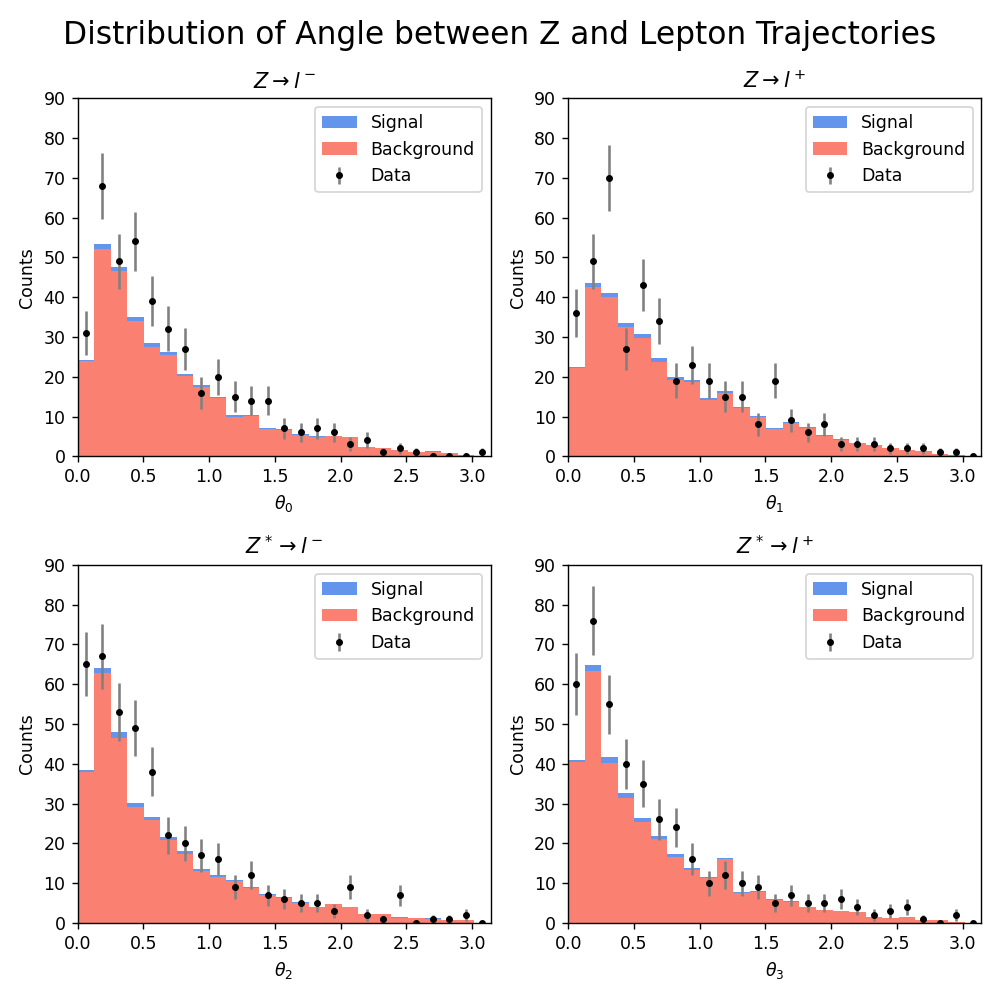

In [37]:
%matplotlib notebook
# lepton angles
nBins = 25
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
ax = {0: ax[0,0], 1: ax[0,1], 2: ax[1,0], 3: ax[1,1]}
lepton_descriptions = {0: r'$Z \rightarrow l^-$', 1: r'$Z \rightarrow l^+$',
                       2: r'$Z^* \rightarrow l^-$', 3: r'$Z^* \rightarrow l^+$'}
for i, name in enumerate(['L0', 'L1', 'L2', 'L3']):
    name += ' a'
    for df, lab in zip([sim, dat], ['MC', 'Data']):
        if lab == 'MC':
            bkg = df[df['sig?'] == 0]
            ax[i].hist(df[name], bins=nBins, range=(0, pi), weights=df['w'], 
                       label='Signal', color='cornflowerblue')
            ax[i].hist(bkg[name], bins=nBins, range=(0, pi), weights=bkg['w'], 
                       label='Background', color='salmon')
        else:
            counts, bins = np.histogram(df[name], bins=nBins, range=(0, pi), weights=df['w'])
            cents = ( bins[1:] + bins[:-1] ) / 2
            ax[i].errorbar(cents, counts, yerr=sqrt(counts), fmt='.k', label=lab, ecolor='grey')
    ax[i].set_xlabel(r'$\theta$'+f'$_{i}$')
    ax[i].set_ylabel('Counts')
    ax[i].set_xlim(0, pi)
    ax[i].set_ylim(0, 90)
    ax[i].legend()
    ax[i].set_title(lepton_descriptions[i])
fig.suptitle('Distribution of Angle between Z and Lepton Trajectories', fontsize=18)
fig.tight_layout()
fig.show()

Once again, the SM simulation clearly matches the angles from the virtual boson (bottom row) better than those from the real (top row).

# Test Accuracy of EEEE/UUUU Pairing
As we know how leptons must be paired in EEUU events, we can pair them by using the z-mass algorithm (used in EEEE and UUUU cases) and compare the results.

In [ ]:
# function to perform llll pairing on eeuu events
def pair_test(df: DataFrame=None, export: bool=True):
    # select eeuu events
    eeuu = df[df['sum_lep_type'] == 48].drop(labels='sum_lep_type', axis=1)
    
    # sort the leptons according to possible z-mass
    llll = partner_llll(eeuu)

    # get Z's and higgs
    zz = MnM(llll)
    h = MnM(zz)

    # merge to single df
    out = merge( *get_angles(llll, zz, h) )

    out.sort_values(by='id', axis=0, inplace=True)
    out.set_index(keys='id', drop=True, inplace=True)
    if export:
        out.to_csv('eeuu.csv')
    else:
        return out
    
pair_test(DF)

In [ ]:
eeuu = pd.read_csv('eeuu.csv')
miss = eeuu[eeuu['L0 type'] != eeuu['L1 type']]

In [74]:
# compare number of events
print('Total Events Frac:')
p = len(miss) / len(eeuu)
print( np.round(p, 3) )

# compare number of non-mc events
print('\nData Events Frac:')
p = len( miss[miss['fam'] >= 10] ) / len( eeuu[eeuu['fam'] >= 10] )
print( np.round(p, 3) )

# compare total weights
print('\nTotal Weights Frac:')
p = miss['w'].sum() / eeuu['w'].sum()
print( np.round(p, 3) )

# compare total weights of events recognized as signal
print('\nSignal Counts Frac:')
p = ( miss['w'] * miss['sig?'] ).sum() / ( eeuu['w']*eeuu['sig?'] ).sum()
print( np.round(p, 3) )

Total Events Frac:
0.431

Data Events Frac:
0.424

Total Weights Frac:
0.442

Signal Counts Frac:
0.201


It's not looking good.

# Ideas and General Notes
* **Ideas**
    * Compare angle distributions of eeuu subset to other subsets, as we have confidence over lepton pairing in eeuu
    * Compare angle as a function of other variables such as Z mass, H mass etc
* **Notes**
    * I will obviously improve the quality of the plots, and generate more. I can think of many combinations and comparisons which would be interesting to have a look at, this is just a proof of concept for now. 